In [11]:
import numpy as np
import torch 
import PAA
from SimulatedData import dataGenerator
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from tqdm import tqdm

from MultiplicativeUpdates import multiplicativeUpdates
from NMI import calcNMI
import seaborn as sns

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
if device == "cuda":
    print('CUDA')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

Using cpu device


In [35]:
alpha = 0.4
ps= 0.6
n_arc = 3
n_features = 3
n_subjects = 300

X,h,tmp,eta = dataGenerator(alpha,ps,n_arc,n_features,n_subjects)
Y = 1-X

In [36]:
torch.Tensor.ndim = property(lambda self: len(self.shape))  # Fix

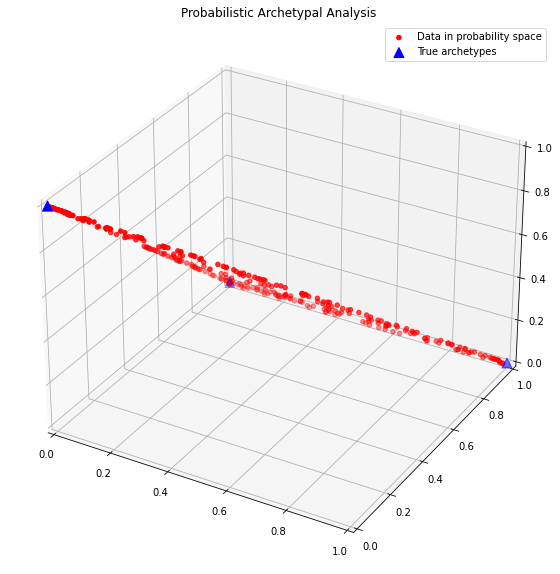

In [37]:
fig =plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
plt.title("Probabilistic Archetypal Analysis")
ax.scatter(tmp[0,:],tmp[1,:],tmp[2,:],c=np.repeat('red', tmp.shape[1]),label="Data in probability space")
ax.scatter(eta[0,:],eta[1,:],eta[2,:], s=100,c=np.repeat('blue', eta.shape[1]), marker='^',label="True archetypes")

#ax.scatter(XC[0,:],XC[1,:],XC[2,:], s=100,c=np.repeat(col3, XC.shape[1]), marker=',',label="Estimated archetypes")
ax.set_xlim3d(0, 1)
ax.set_ylim3d(0, 1)
ax.set_zlim3d(0, 1)
ax.legend()
plt.show()

In [42]:
mlosses = [[ ]]
mCost_old = torch.tensor([15000])
mCost = torch.tensor([10000])
tol = torch.tensor([1e-6])
n_epochs = torch.tensor([1500])
epoch = torch.tensor([0])

types = torch.arange(1,10,1)
#i = 0
costs = torch.zeros([len(types),5])
G_all = np.zeros([5,len(types)],dtype = object)


mW = torch.FloatTensor(n_subjects, n_arc).uniform_(0,1).to(device)
mG = torch.FloatTensor(n_arc,n_subjects).uniform_(0,1).to(device)
mW_norm = torch.divide(mW,(mW).sum(axis=0)).to(device)    
mG_norm = torch.divide(mG,(mG).sum(axis=0)).to(device)
Y = (1-X).clip(min=0).to(device) 
P = X.clip(min=0.00001,max=0.999999)
Q = Y.clip(min=0.00001,max=0.999999)


for s in tqdm(range(5)):
    i = 0
    #print(s)
    for t in types:
        


        mlosses = []
        mCost_old = torch.tensor([15000])
        mCost = torch.tensor([10000])
        epoch = torch.tensor([0])
        mW = torch.FloatTensor(n_subjects, t).uniform_(0,1).to(device)
        mG = torch.FloatTensor(t,n_subjects).uniform_(0,1).to(device)
        mW_norm = torch.divide(mW,(mW).sum(axis=0)).to(device)    
        mG_norm = torch.divide(mG,(mG).sum(axis=0)).to(device)

        while (epoch<n_epochs and torch.abs(mCost_old-mCost)>tol):

            mCost_old = mCost
            mG,mG_norm = multiplicativeUpdates().G_update(X,Y,P,Q,mG,mG_norm,mW, mW_norm)
            mW,mW_norm =multiplicativeUpdates().W_update(X,Y,P,Q,mG,mG_norm,mW, mW_norm)
            mCost = multiplicativeUpdates().costFunc(X,Y,P,Q,mG_norm,mW_norm)

            mlosses.append(mCost)

            epoch +=1
        #print(epoch) 
        
        costs[i,s] = mlosses[-2]
        G_all[s,i] = mG_norm.cpu().numpy()
        i+=1

100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


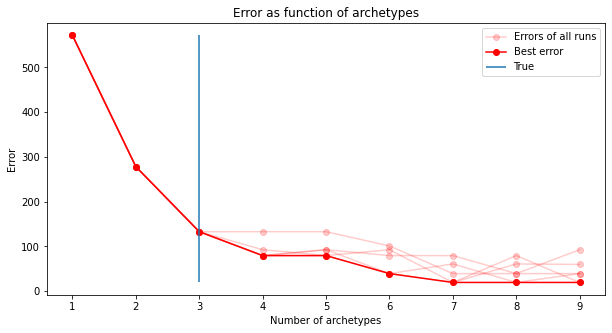

In [43]:

val,ind = torch.min(costs,1)


fig, ax = plt.subplots(figsize=(10,5))
plt.plot(types,costs[:,0], '-o',color='red',alpha=0.2,label = "Errors of all runs")
plt.plot(types,costs[:,1:], '-o',color='red',alpha=0.2,label = "_Error")
plt.plot(types,val,'-o',color='red',label = "Best error")
plt.title("Error as function of archetypes")
ax.set_xlabel("Number of archetypes")
ax.set_ylabel("Error")
ax.vlines(x=n_arc, linestyle='solid',ymin=torch.min(val),ymax=torch.max(val),label="True")

ax.legend()

plt.show()

In [44]:
data = G_all
types = np.arange(1,10,1) 
score = np.zeros([5,len(types)])
for f in range(0,5):
    for p in range(1,len(types)):
        
        score[f,p] = calcNMI(data[f][p],data[f-1][p])
        
for p in range(1,len(types)):

    score[0,p] = calcNMI(data[0][p],data[4][p])

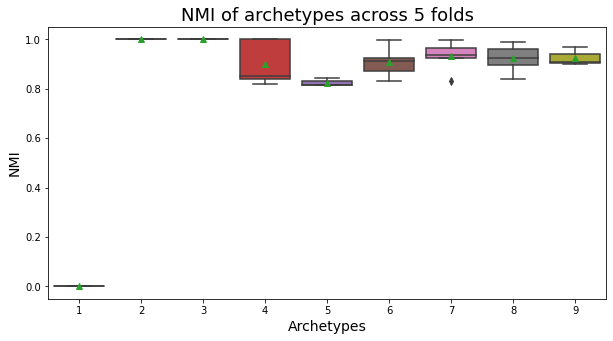

In [45]:
fig, ax = plt.subplots(1,1,figsize = (10,5))
sns.boxplot(data=score, 
            showmeans=True)
ax.set_ylabel("NMI", size=14)
ax.set_xlabel("Archetypes", size=14)
plt.title("NMI of archetypes across 5 folds", size=18)
ax.set_xticks(range(len(types)))
ax.set_xticklabels(types.astype(str))

plt.show()